In [46]:
#%%imports
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
import importlib
from typing import Union, Any

from astroLuSt.ai import bubbles as alb

plt.style.use('astroLuSt.styles.LuSt_style')

# ND-BUBBLES
(**N**oise **D**etecting) **B**lueprint **U**sing **B**uilding **B**lock **L**abel **E**stimation (in **S**pace)

Let's generate some dataset.

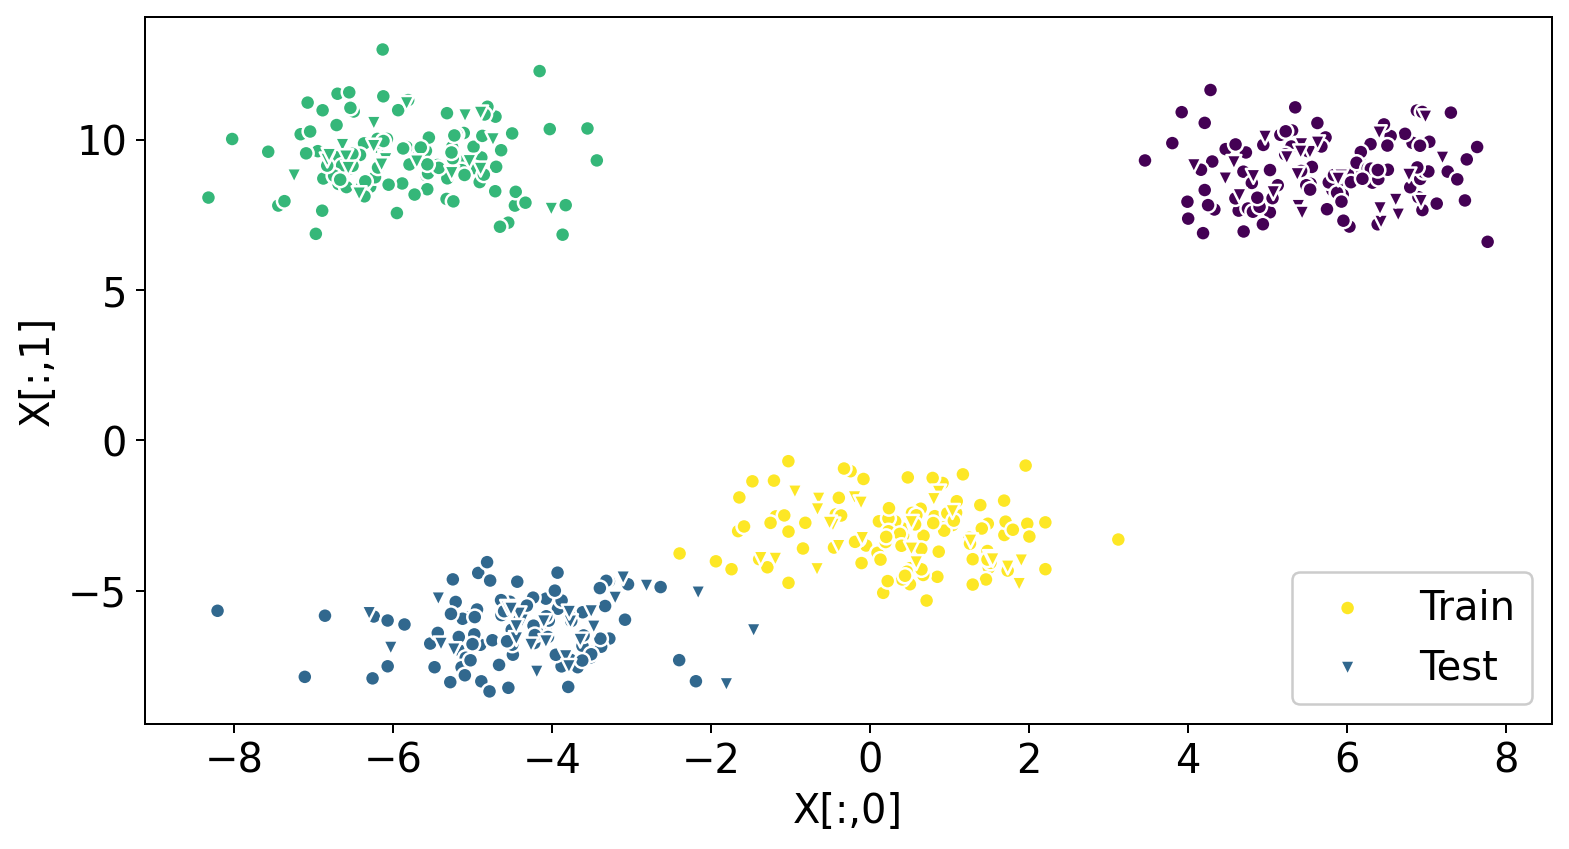

In [4]:

n = 500
X, y = make_blobs(n_samples=n, n_features=4, centers=4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*X_train[:,:2].T, c=y_train, marker='o', ec='w', label='Train')
ax1.scatter(*X_test[:,:2].T,  c=y_test,  marker='v', ec='w', label='Test')
ax1.set_xlabel('X[:,0]')
ax1.set_ylabel('X[:,1]')
ax1.legend()
plt.show()



Using the internal functions

BUBBLES(
    func='sphere',
    r0=2.5, min_pts=0,
    res=10,
    n_jobs=2,
    verbose=0,
)
Labels: [-1.  0.  1.  2.  3.]
Counts: [25 17 22 15 21]


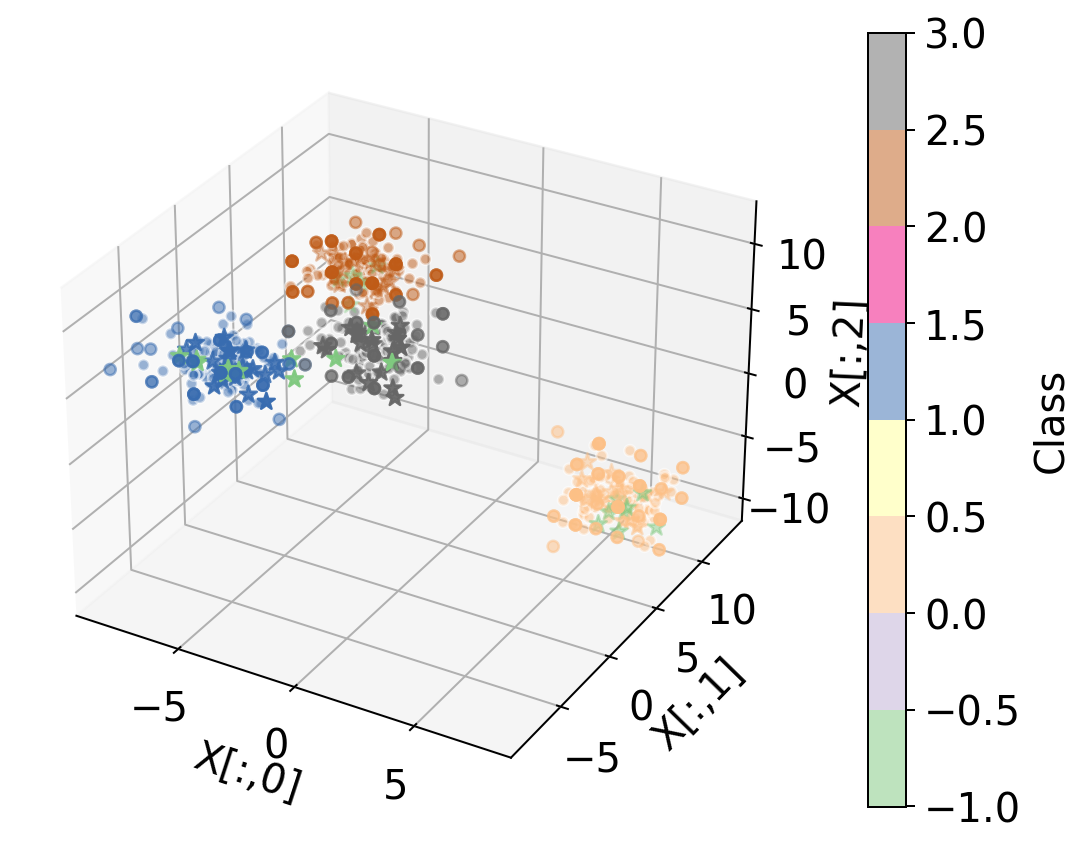

In [38]:
importlib.reload(alb)

BB = alb.ND_BUBBLES(
    func='sphere',
    # func='rect',
    r0=2.5, min_pts=0,
    res=10,
    n_jobs=2,
    verbose=0,
)
print(BB)

BB.fit(
    X_train, y_train,
)

y_pred_test = BB.predict(
    # X_train,
    X_test
)

labs, counts = np.unique(y_pred_test, return_counts=True)
print(f'Labels: {labs}')
print(f'Counts: {counts}')

fig, axs = BB.plot_result(
    X_train, y_train,
    features=[0,1,2],
)
#including test data
axs[0].scatter(*X_test[:,[0,1,2]].T, c=y_pred_test, s=50, marker='*', vmin=-1, cmap='Accent')
plt.show()

Defining a custom `func`

{'func': <function testfunc at 0x00000233C54949D0>, 'r0': 3, 'min_pts': 0, 'res': 10, 'n_jobs': 2, 'verbose': 0}


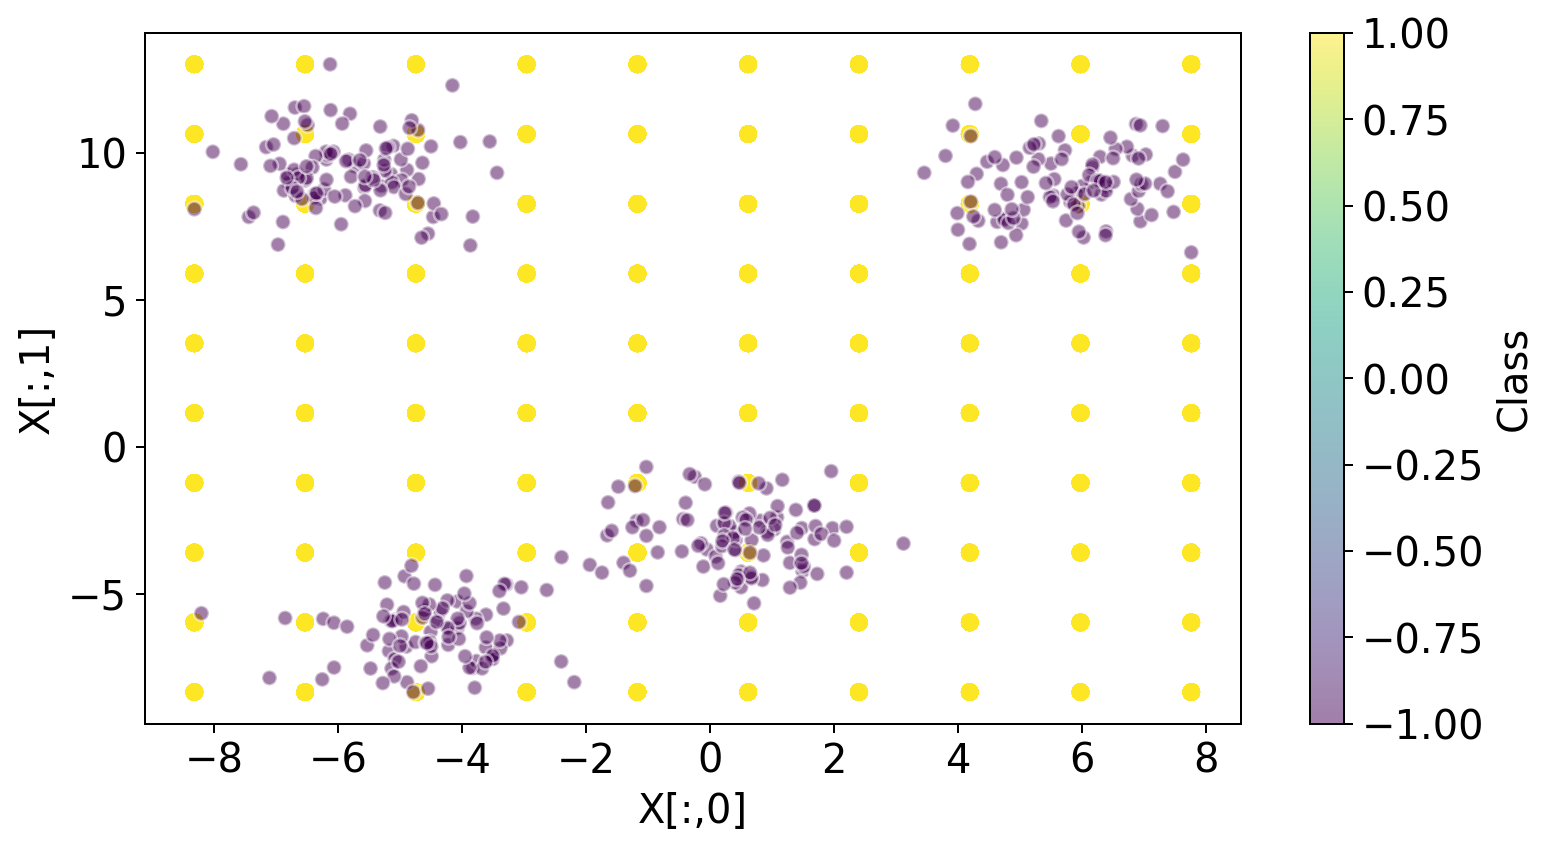

In [39]:
importlib.reload(alb)

def testfunc(
    X,
    y=None, X_grid=None, r0=None, min_pts=None,
    fit=True
    ) -> Union[np.ndarray,Any]:
    """
        - custom function to use instead of `sphere` and `rect`
        - will assign the label 1 to every point in `X_grid` during fitting
        - will assign -1 (noise) to every single point during prediction

        Parameters
        ----------
            - as specified in the classifier's documentation

        Raises
        ------
            - as specified in the classifier's documentation

        Returns
        -------

        Comments
        --------
    """

    if fit:
        return np.append(X_grid, 1)
    else:
        return -1
    
BB = alb.ND_BUBBLES(
    func=testfunc,
    r0=3, min_pts=0,
    res=10,
    n_jobs=2,
    verbose=0,
)
y_pred = BB.fit_predict(X_train, y_train)

#get clf parameters
params = BB.get_parameters()
print(params)

#plot result
fig, axs = BB.plot_result(
    X_train, y_pred,
    features=[0,1],
    cmap='viridis'
)
plt.show()

Works for different cluster-shapes

In [40]:
X_m, y_m = make_moons(n_samples=n, noise=0.2)
X_c, y_c = make_circles(n_samples=n, noise=0.1)

X_m_tr, X_m_te, y_m_tr, y_m_te = train_test_split(X_m, y_m, test_size=0.2)
X_c_tr, X_c_te, y_c_tr, y_c_te = train_test_split(X_c, y_c, test_size=0.2)

Accuracy: 0.94


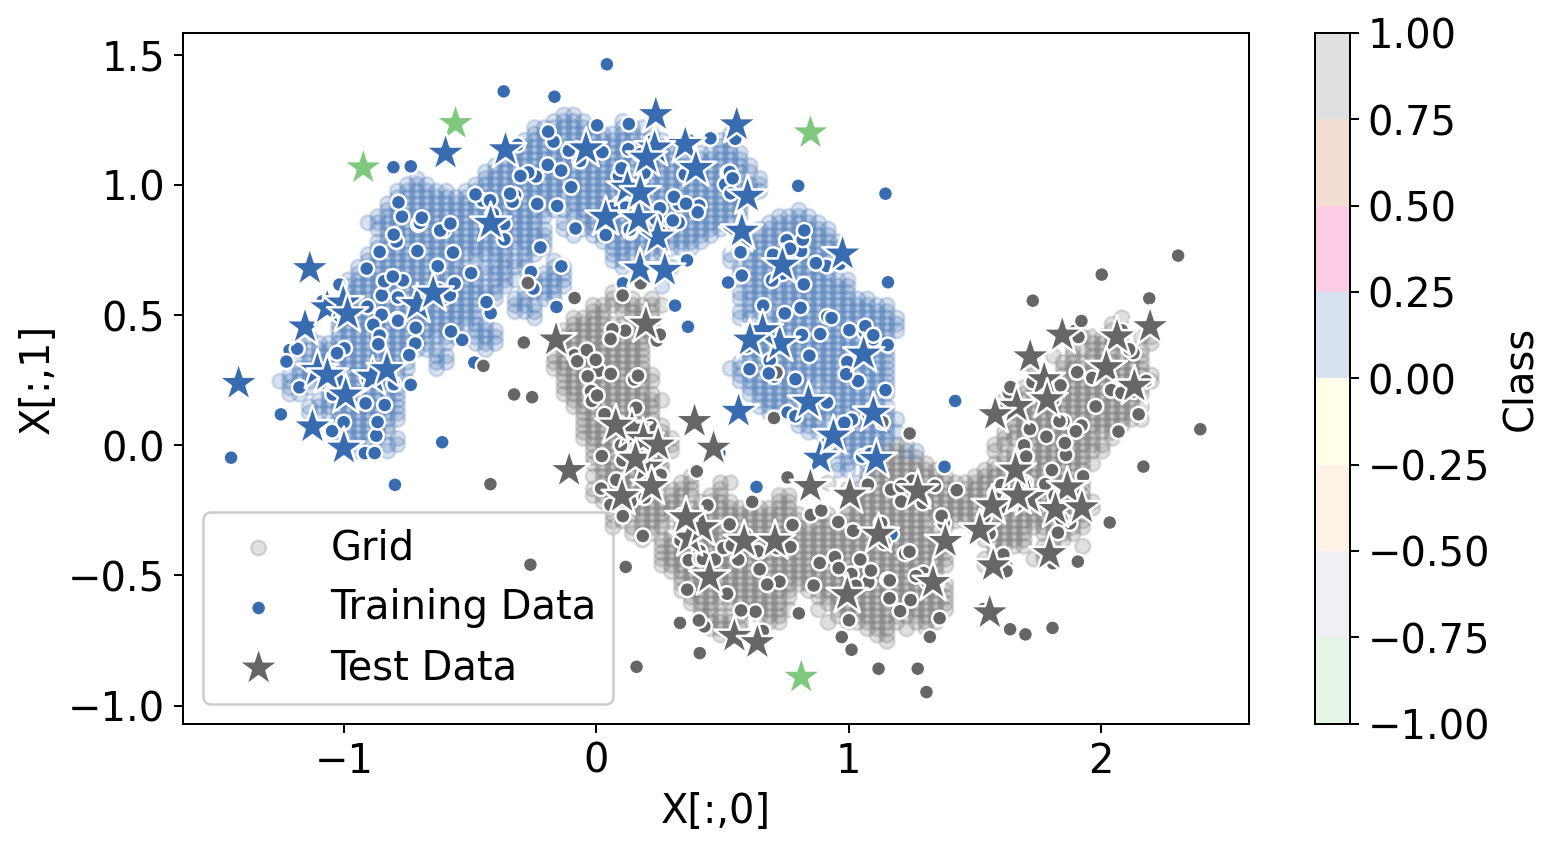

In [45]:
BB = alb.ND_BUBBLES(
    'sphere',
    r0=0.2, min_pts=5,
    res=50,
    n_jobs=2,
    verbose=0
)

BB.fit(
    X_m_tr, y_m_tr
)
y_pred_test = BB.predict(X_m_te)

#score fitted classifier
print(f'Accuracy: {BB.score(X_m_te, y_m_te)}')

fig, axs = BB.plot_result(
    X_m_tr, y_m_tr,
    cmap='Accent',
    grid_scatter_kwargs={'alpha':0.2, 'vmin':-1,           'label':'Grid'},
    data_scatter_kwargs={'alpha':1.0, 'vmin':-1, 'ec':'w', 'label':'Training Data'},
)

axs[0].scatter(*X_m_te.T, c=y_pred_test, s=300, marker='*', ec='w', vmin=-1, cmap='Accent', label='Test Data')

axs[0].legend()
plt.show()

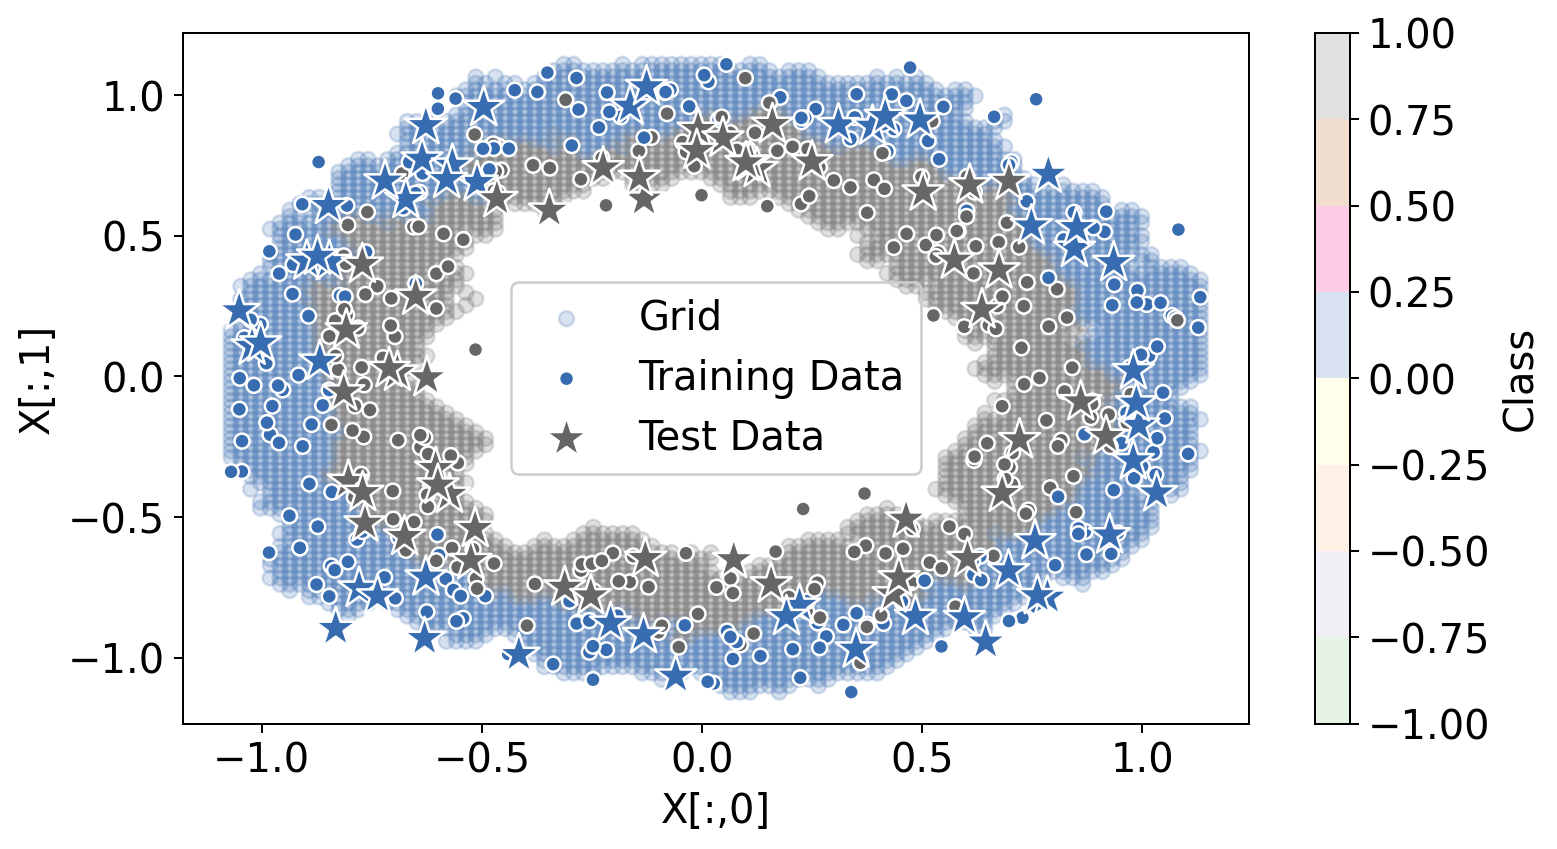

In [44]:
BB = alb.ND_BUBBLES(
    'sphere',
    r0=0.2, min_pts=5,
    res=50,
    n_jobs=2,
    verbose=0
)

BB.fit(
    X_c_tr, y_c_tr
)
y_pred_test = BB.predict(X_c_te)

fig, axs = BB.plot_result(
    X_c_tr, y_c_tr,
    cmap='Accent',
    grid_scatter_kwargs={'alpha':0.2, 'vmin':-1,           'label':'Grid'},
    data_scatter_kwargs={'alpha':1.0, 'vmin':-1, 'ec':'w', 'label':'Training Data'},
)

axs[0].scatter(*X_c_te.T, c=y_pred_test, s=300, marker='*', ec='w', vmin=-1, cmap='Accent', label='Test Data')

axs[0].legend()
plt.show()

## Intended Usage

The initial idea for `ND-BUBBLES` was to use it as a pipeline element after classifier, that need to be refitted every time they want to make a prediction.
I.e. classifiers where the prediction is dependent on a stored dataset.
In sklearn such classifiers only have a `fit_predict()` method and no `predict()` method.
An example would be `DBSCAN`.

[-1  0  1]


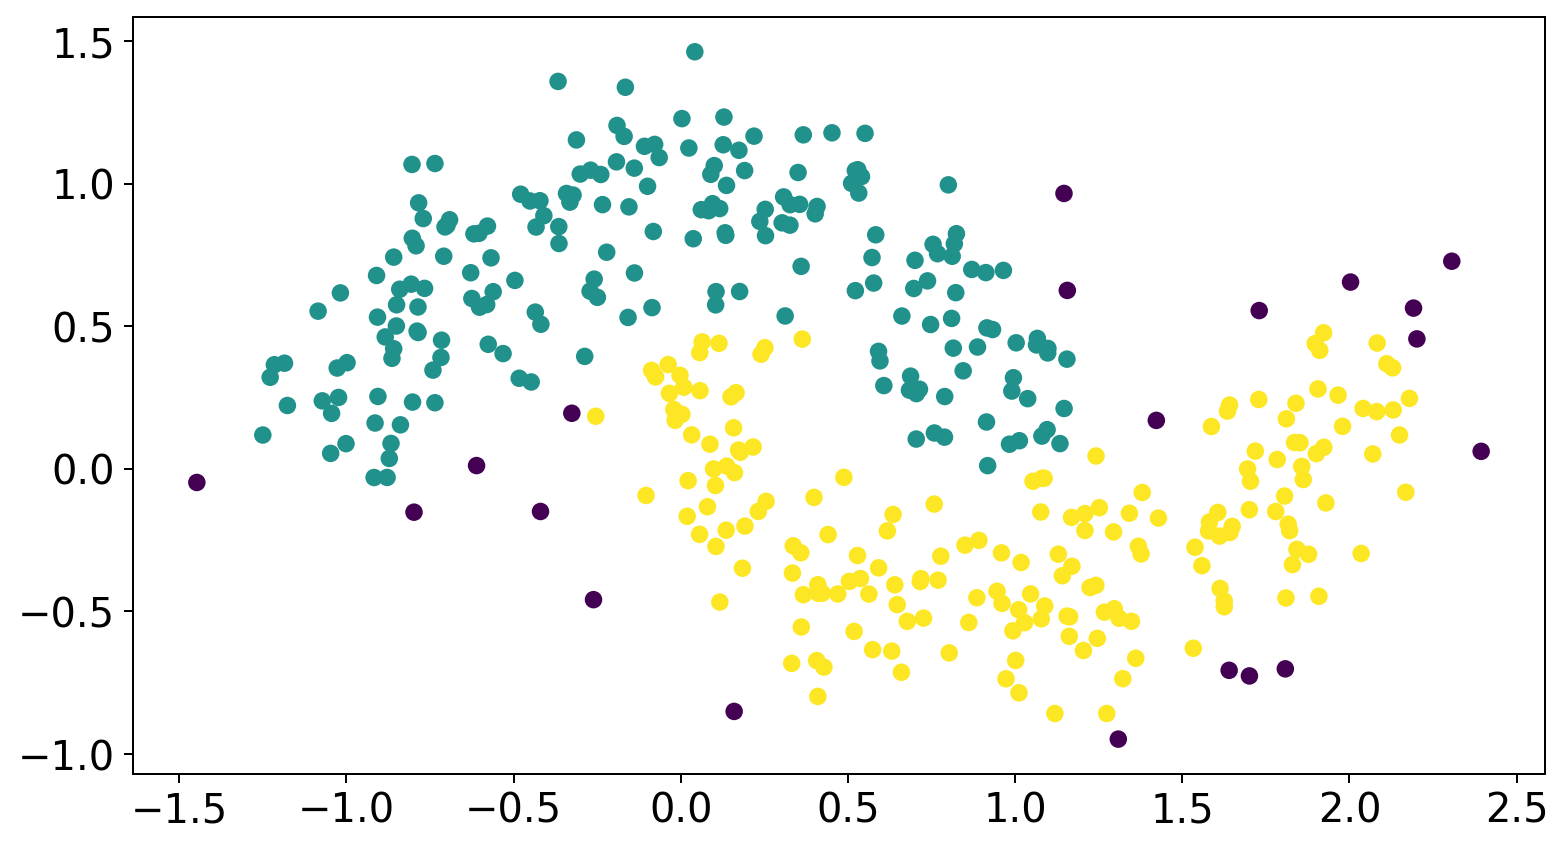

In [67]:
from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=0.25, min_samples=17)  #has no .predict() method

y_pred_dbscan = clf.fit_predict(X=X_m_tr)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(*X_m_tr.T, c=y_pred_dbscan)
plt.show()



Let's add a `ND-BUBBLES` instance and make predictions on a test set.

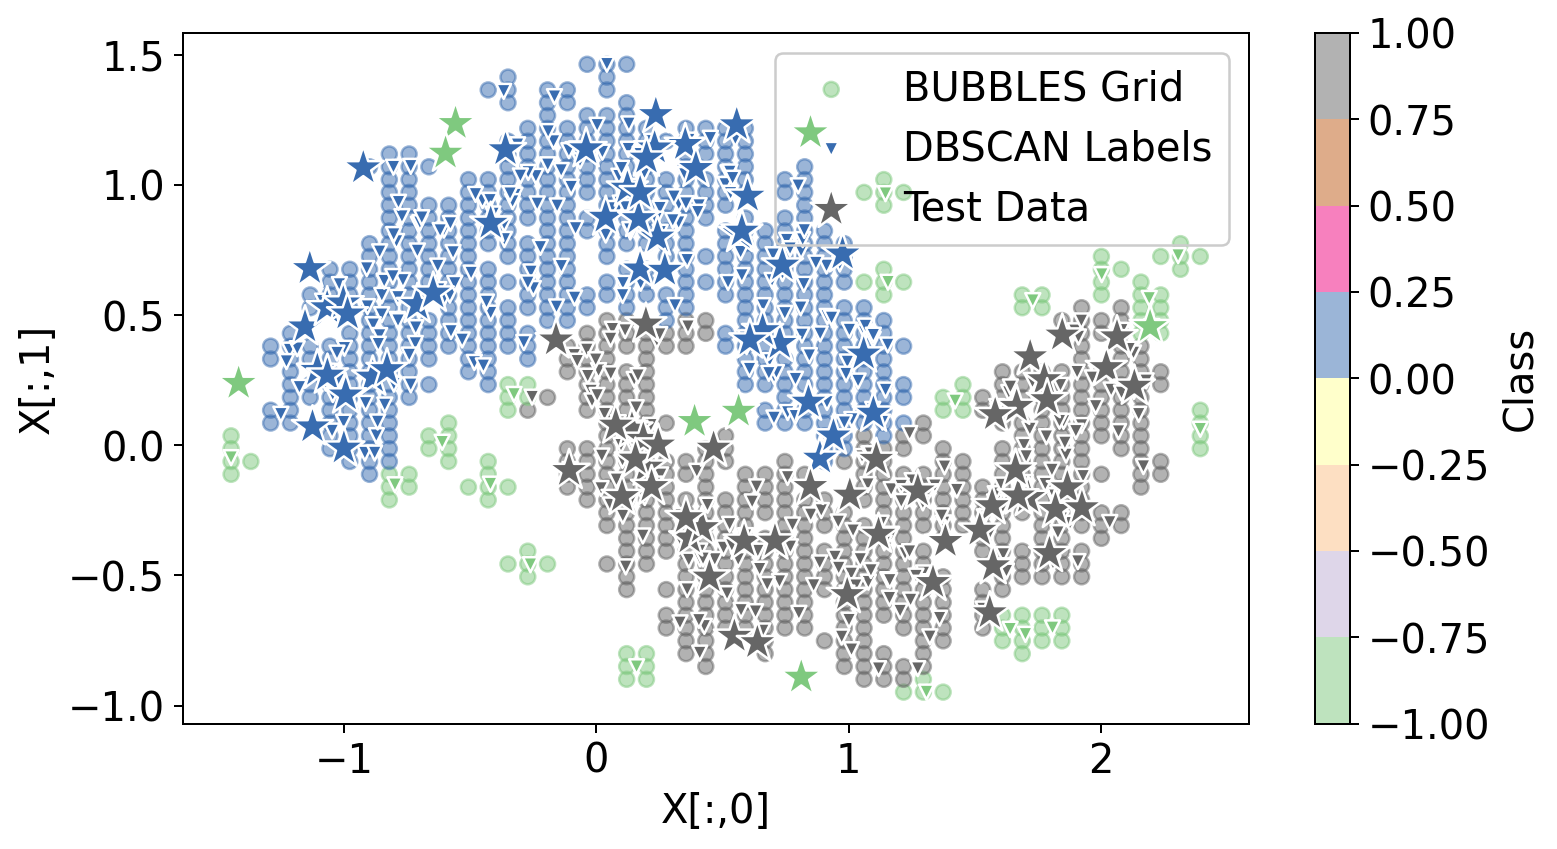

In [75]:
BB = alb.ND_BUBBLES(
    func='sphere',
    r0=0.1, min_pts=0,
    res=50,
    n_jobs=2,
)

BB.fit(X_m_tr, y_pred_dbscan)

#can predict on new points without refitting
y_pred_test = BB.predict(X_m_te)

fig, axs = BB.plot_result(
    X_m_tr, y_pred_dbscan,
    grid_scatter_kwargs={'alpha':0.5, 'vmin':-1,           'marker':'o', 'label':'BUBBLES Grid'},
    data_scatter_kwargs={'alpha':1.0, 'vmin':-1, 'ec':'w', 'marker':'v', 'label':'DBSCAN Labels'},
)

axs[0].scatter(*X_m_te.T, c=y_pred_test, s=300, marker='*', ec='w', vmin=-1, cmap='Accent', label='Test Data')

axs[0].legend()
plt.show()